# Procesamiento Básico de Señal Digital para Relés

Trabajo presentado por: 
- Andrés Enrique Avila Rojas
- Carlos Salomón Saenz Díaz
- Alberto Bérmudes Arias
- Valentina Reyes Martínez

In [28]:
# Modulos necesarios
import numpy as np
from scipy import signal, fftpack
from matplotlib import pyplot as plt
from scipy.io import loadmat
import cmath 
import pandas as pd
from IPython.display import display

# Parámetros de entrada del Relé:
Entre los parámetros que se incluyen en para interacción del usuario están los siguientes: 
- Archivo de datos de entrada al módulo DSP (en este caso .mat).
- Relación de los transformadores de intrumentación.
- Número de muestras por ciclo que el usuario desea análizar (4, 8, 16, 32 o 64)
- Tiempo de disparo de zona 2 para la configuración de la función de distancia (21)
- Tiempo de activación de la función de sobrecorriente normalmente inversa (51)
- Impedancia de la línea a proteger.
- Porcentaje de definición de las zonas de la característica Mho.

In [29]:
# ARCHIVO .mat
# Este archivo debe tener un registro de al menos 0.7 segundos después de la generación de la falla
mat = loadmat('Falla_ACG_L_INT_100ohm.mat')# El archivo se selecciona desde la interfaz

# RELACIÓN DE TRANSFORMADORES DE INTRUMENTACIÓN
ratio_CT =2000/5 #Usado en el cálculo de impedancia
ratio_PT = 241000/110



## Definición de métodos a Utilizar

A continuación se definen las funciones para el cálculo completo de las etapas del procesamiento digital de la señal para un relé.

### Etapa de submuestreo

Se muestrea a la frecuencia de muestro del relé estipulada por el usuario

In [30]:
def subsampling(time,data,fs,fk,fs_user_cycle):
    # time is the vector of time
    # data is the vector with the signal
    # fs_comtrade is the sample rate from the comtrade file
    # fk is the frequency of the system
    # fs_user_cycle is the sample rate given by user
    N1 = fs_user_cycle
    fs_cycle = fs/fk
    N=np.int(fs_cycle)
    N_tot = np.int(len(data)/fs_cycle)
    new_data = [0]
    new_time = [0]
    for i in np.arange(N_tot):
        xi=data[i*N:i*N+N]
        ti=time[i*N:i*N+N]
        new_data[i*N1:i*N1+N1] = signal.resample(xi, N1)
        new_time[i*N1:i*N1+N1] = np.linspace(ti[0], ti[-1], N1, endpoint=False)
        
    return (new_time,new_data)

### Modulo de S&H y A/D (Quantizer)

Método para digitalizar la señal de entrada

In [31]:
def quantizer(data, quantizing_bits):
    # data is the vector with the signal
    # quantizing_bits is the number of bits for the converter
    # Quantizer - S&H and ADC
    quantizing_levels   = 2 ** quantizing_bits
    quantizing_step     = (np.max(data)-np.min(data)) / quantizing_levels
    quantizing_signal   = np.round (data / quantizing_step) * quantizing_step;
    
    return quantizing_signal

### Transformada de Fourier (Filtro de componentes ortogonales basado en filtro coseno)

Se presenta la transformada directa de Fourier con el ventaneo de la señal, teniendo la siguiente representación en componentes ortogonales.

$$X_c = \frac{2}{N}\sum_{k=0}^{N-1} x_k \cos \left(\frac{2\pi}{N} k \right)$$

$$X_s = -\frac{2}{N}\sum_{k=0}^{N-1} x_k \sin \left(\frac{2\pi}{N} k \right)$$

In [32]:
def DFT(time, data, fk, fs_user_cycle):
    # time is the vector of time
    # data is the vector with the signal
    # fk is the frequency of the system
    # fs_user_cycle is the sample rate given by user
    
    N=np.int(fs_user_cycle)
    N_tot = len(data)-N
    Xc = [0]*N_tot
    Xs = [0]*N_tot
    t = [0]*N_tot
    
    # Ciclo para el ventaneo
    for i in np.arange(N_tot):
        xi=data[i:i+N]
        t[i]=time[i]
        Xc_sum = 0
        Xs_sum = 0
        # Ciclo para el filtro coseno
        for k in np.arange(N):
            Xc_temp=xi[k]*np.cos(2*np.pi*k/(N))
            Xc_sum=Xc_sum+Xc_temp
            Xs_temp=xi[k]*np.sin(2*np.pi*k/(N))
            Xs_sum=Xs_sum+Xs_temp
            
        Xc[i]= 2/(N*np.sqrt(2))*Xc_sum
        Xs[i]= -2/(N*np.sqrt(2))* Xs_sum
        
    return t, Xc, Xs

## Obtención de Salidas del Programa (Gráficas y lectura de datos)

### Se obtienen y grafican los datos del archivo .mat

Se debe hacer una conversión de la versión obtenida de ATP a una versión -v7 (Ver Change_version.m)

Record has 52290 samples
Sampling rate is 1000016 samples/sec.


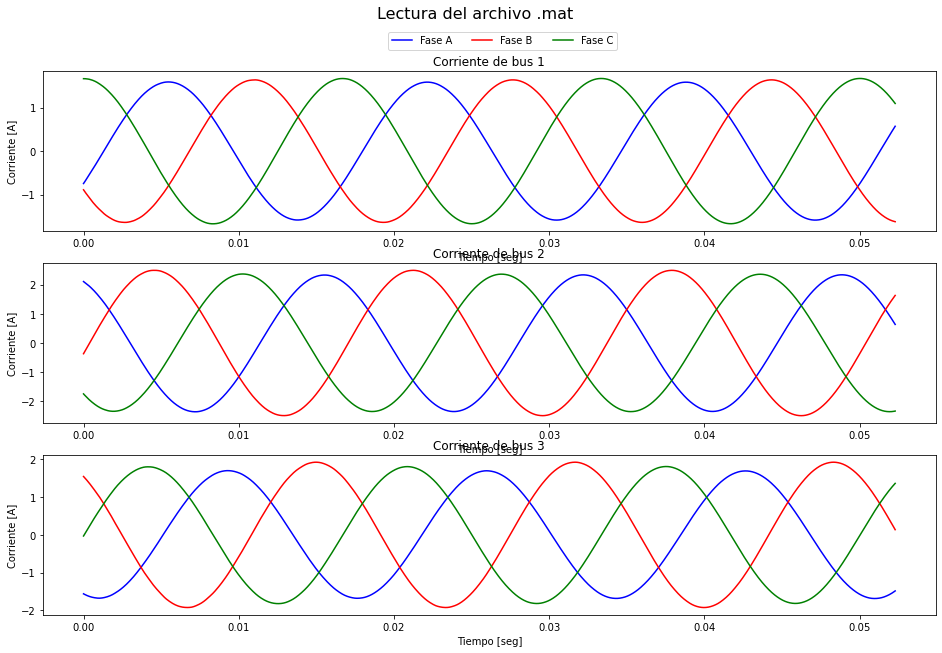

In [33]:
# Reading time vector:
time = mat['t'] #Se conoce que todos los archivos vendrán con este vector incluido

N = len(time)
fs = np.int(np.ceil(len(time)/time[-1])-4)

print('Record has {} samples'.format(N))
print('Sampling rate is {} samples/sec.'.format(fs))


# Line frequency in Hz
fk = 60 # It can be set automatically


# Reading  currents

currents_bus1 = np.empty(([len(time),3]))
currents_bus2 = np.empty(([len(time),3]))
currents_bus3 = np.empty(([len(time),3]))
#voltages_bus2 = np.empty(([len(time),3]))


col=0
for i in ['a','b','c']:
    
    currents_bus1[:,col] = mat['iCt1'+i].ravel()
    currents_bus2[:,col] = mat['iCt2'+i].ravel()
    currents_bus3[:,col] = mat['iCt3'+i].ravel()
    col=col+1
    
#measures = [voltages_bus1,currents_bus1,voltages_bus2,currents_bus2]
#print(N_tot)
measures = [currents_bus1,currents_bus2,currents_bus3]
            
f, axarr = plt.subplots(3,1, figsize =(16, 10))
f.suptitle('Lectura del archivo .mat', y=0.97, fontsize=16)
labels = ['Fase A', 'Fase B', 'Fase C']

n_bus=1
for i in range(len(measures)):
    
        p1 = 1
        p2 = i
        axarr[p2].set_title(('Corriente de bus '+str(n_bus)))
        axarr[p2].set_ylabel('Corriente [A]')
        
        
        axarr[p2].set_xlabel('Tiempo [seg]')
        
        axarr[p2].plot(time, measures[i][:,0], 'b-', label='Fase A')
        axarr[p2].plot(time, measures[i][:,1], 'r-', label='Fase B')
        axarr[p2].plot(time, measures[i][:,2], 'g-', label='Fase C')
        
        n_bus=n_bus+1
        
f.legend(axarr[1].get_lines(), labels, ncol=3, bbox_to_anchor=(0.54, 0.87))

Ejemplo con Falla Bifásica entre B y C.

### Etapa de Conversión A/D

### Etapa de Filtros Ortogonales

Inicialmente se muestran las gráficas de magnitud de las señales, mostrando el comportamiento a lo largo del tiempo del archivo COMTRADE leído previamente, y luego se muestra la variación en fase de estas mismas señales.

In [38]:



fft1 = np.fft.fft(measures[:][i])
fft2 = np.fft.fft(measures[:][i])
fft3 = np.fft.fft(measures[:][i])
afft1= np.empty(([len(time),3]))
print(fft1)
for i in range((3)):
    for j in range((3)):
        mfft1[i][j]=abs(fft1[i][j])
        afft1[i][j]= cmath.phase((fft1[i][j]).real,(fft1[i][j]).imag)
        
print(mfft1)
print(afft1)



# PLOTING -----------------------------------------------------------------
f, axarr = plt.subplots(6, 2, figsize =(16, 25))
f.suptitle('FFT En Magnitud', y=0.92, fontsize=16)
labels_X = ['DFT Fase A','DFT Fase B', 'DFT Fase C']
cont = 0
for i in range(len(measures_X)):
    axarr.flat[0].set_title(r'$\bf{Bus 1}$',x=1.09, fontsize=14)
    axarr[3,0].set_title(r'$\bf{Bus 2}$',x=1.09, fontsize=14)
    for j in np.arange(3):
        if (cont % 2)==0: #Si es par
            p1 = np.int(cont/2)
            p2 = 0
            axarr[p1,p2].set_ylabel('Voltaje [V]')
        else:
            p1 = np.int(np.ceil(cont/2)-1)
            p2 = 1
            axarr[p1,p2].set_ylabel('Corriente [A]')
        if (i<2):
            p1 = j
            if (i%2)==0: p2=0
            else: p2=1
        else:
            p1 = j + 3
            if (i%2)==0: p2=0
            else: p2=1
        axarr[p1,p2].set_xlabel('Tiempo [seg]')
        axarr[p1,p2].plot(time_sub[:,i], measures_sub[i][:,j], colors[j], label=labels[j])
        axarr[p1,p2].plot(t[:,i], measures_X[i][:,j], colors_sub_dig[j], label=labels_X[j])
        axarr[p1,p2].legend()
        cont = cont + 1
        

[[-0.04575355+0.j         -2.32105562-1.36543029j -2.32105562+1.36543029j]
 [-0.04573191+0.j         -2.32148862-1.3649287j  -2.32148862+1.3649287j ]
 [-0.04570898+0.j         -2.32183965-1.36395276j -2.32183965+1.36395276j]
 ...
 [ 0.01578182+0.j         -2.23753205+1.06049529j -2.23753205-1.06049529j]
 [ 0.01580982+0.j         -2.23709061+1.06151612j -2.23709061-1.06151612j]
 [ 0.0158377 +0.j         -2.23664893+1.06253675j -2.23664893-1.06253675j]]


TypeError: phase() takes exactly one argument (2 given)

Grafica de Fases

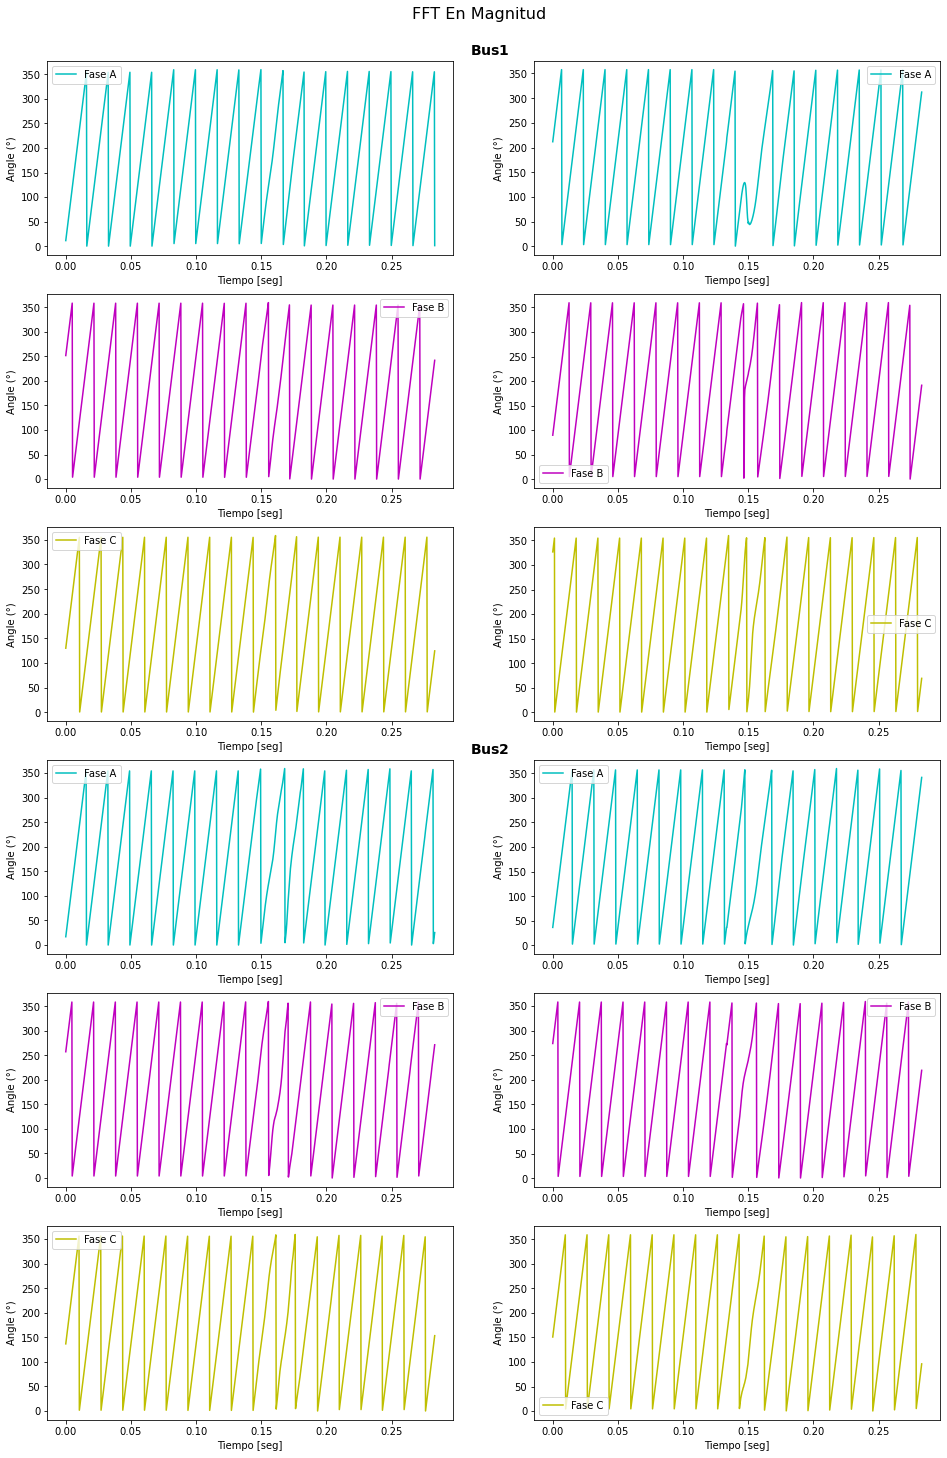

In [10]:
# PLOTING -----------------------------------------------------------------
f, axarr = plt.subplots(6, 2, figsize =(16, 25))
f.suptitle('FFT En Magnitud', y=0.91, fontsize=16)
cont = 0
for i in range(len(measures_Y)):
    axarr.flat[0].set_title(r'$\bf{Bus 1}$',x=1.09, fontsize=14)
    axarr[3,0].set_title(r'$\bf{Bus 2}$',x=1.09, fontsize=14)
    for j in np.arange(3):
        if (i<2):
            p1 = j
            if (i%2)==0: p2=0
            else: p2=1
        else:
            p1 = j + 3
            if (i%2)==0: p2=0
            else: p2=1
        axarr[p1,p2].set_xlabel('Tiempo [seg]')
        axarr[p1,p2].set_ylabel('Angle (°)')
        axarr[p1,p2].plot(t[:,i], measures_Y[i][:,j], colors_sub_dig[j], label=labels[j])
        axarr[p1,p2].legend()
        cont = cont + 1

## Detección del instante falla
Se detecta la falla mediante la comparación de la amplitud de la onda en cada instante del tiempo y el voltaje nominal del sistema, si el voltaje nominal está por debajo del 90% se detecta una falla.

In [11]:
pos_tf1=0
for i in range(len(X_bus1_V)):
    V_nom = 115/np.sqrt(3)
    p = 0.8 #Criterio de comparación
    phA = X_bus1_V[i,0]
    phB = X_bus1_V[i,1]
    phC = X_bus1_V[i,2]
    if phA < V_nom*p or phB < V_nom*p or phC < V_nom*p:
        pos_tf1=i
        break

pos_tf = pos_tf1+fs_user_cycle*4 # Se esperan 4 ciclos para determinar 

# RESULTADOS DE FASORES

En este punto se muestra una foto del último valor de la magnitud y la fase de la señal, es decir en el momento un momento de prefalla y en un momento en el que la falla ya se ha estabilizado.

**Valores de Voltaje y Corriente**

Presenta el valor de los fasores en un instante de pre falla post falla en la medición de los dos buses terminales de la línea.

In [12]:
fase = ['A','B','C']
print('BUS 1'+'\n\n'+'Operación Normal')
# Voltajes
for i in range(len(fase)):
    print('Voltaje fase'+ fase[i]+ ':'+ "{:.2f}".format(np.double(X_bus1_V[0,i])), 'V', "{:.2f}".format(np.double(Y_bus1_V[0,i])),'°')
#Corrientes
for i in range(len(fase)):
    print('Corriente fase', fase[i], ':', "{:.2f}".format(np.double(X_bus1_I[0,i])), 'A', "{:.2f}".format(np.double(Y_bus1_I[0,i])),'°')

print('\nFalla')
# Voltajes
for i in range(len(fase)):
    print('Voltaje fase'+ fase[i]+ ':'+ "{:.2f}".format(np.double(X_bus1_V[pos_tf,i])), 'V', "{:.2f}".format(np.double(Y_bus1_V[-1,i])),'°')
#Corrientes
for i in range(len(fase)):
    print('Corriente fase', fase[i], ':', "{:.2f}".format(np.double(X_bus1_I[pos_tf,i])), 'A', "{:.2f}".format(np.double(Y_bus1_I[-1,i])),'°')


print('\n\nBUS 2'+'\n\n'+'Operación Normal')
# Voltaje
for i in range(len(fase)):
    print('Voltaje fase', fase[i], ':', "{:.2f}".format(np.double(X_bus2_V[0,i])), 'V', "{:.2f}".format(np.double(Y_bus2_V[0,i])),'°')
#Corriente
for i in range(len(fase)):
    print('Corriente fase', fase[i], ':', "{:.2f}".format(np.double(X_bus2_I[0,i])), 'A', "{:.2f}".format(np.double(Y_bus2_I[0,i])),'°')
    
print('\nFalla')
# Voltaje
for i in range(len(fase)):
    print('Voltaje fase', fase[i], ':', "{:.2f}".format(np.double(X_bus2_V[pos_tf,i])), 'V', "{:.2f}".format(np.double(Y_bus2_V[-1,i])),'°')
#Corriente
for i in range(len(fase)):
    print('Corriente fase', fase[i], ':', "{:.2f}".format(np.double(X_bus2_I[pos_tf,i])), 'A', "{:.2f}".format(np.double(Y_bus2_I[-1,i])),'°')

BUS 1

Operación Normal
Voltaje faseA:66.58 V 11.25 °
Voltaje faseB:67.11 V 251.58 °
Voltaje faseC:67.66 V 130.18 °
Corriente fase A : 1.45 A 211.74 °
Corriente fase B : 1.51 A 89.53 °
Corriente fase C : 1.45 A 326.70 °

Falla
Voltaje faseA:26.43 V 1.01 °
Voltaje faseB:25.98 V 241.88 °
Voltaje faseC:26.37 V 124.76 °
Corriente fase A : 5.52 A 312.27 °
Corriente fase B : 5.66 A 191.35 °
Corriente fase C : 5.58 A 69.05 °


BUS 2

Operación Normal
Voltaje fase A : 69.30 V 16.88 °
Voltaje fase B : 69.82 V 257.20 °
Voltaje fase C : 70.11 V 136.55 °
Corriente fase A : 1.41 A 36.29 °
Corriente fase B : 1.49 A 273.87 °
Corriente fase C : 1.44 A 150.80 °

Falla
Voltaje fase A : 7.77 V 25.31 °
Voltaje fase B : 7.22 V 271.36 °
Voltaje fase C : 7.86 V 153.24 °
Corriente fase A : 10.82 A 341.51 °
Corriente fase B : 11.41 A 219.33 °
Corriente fase C : 11.13 A 96.07 °


**Gráficas de Fasores** 

Se presentan los diagramas fasoriales de las señales en un instante de pre-falla y en un instante de falla.

PRE-FALLA:

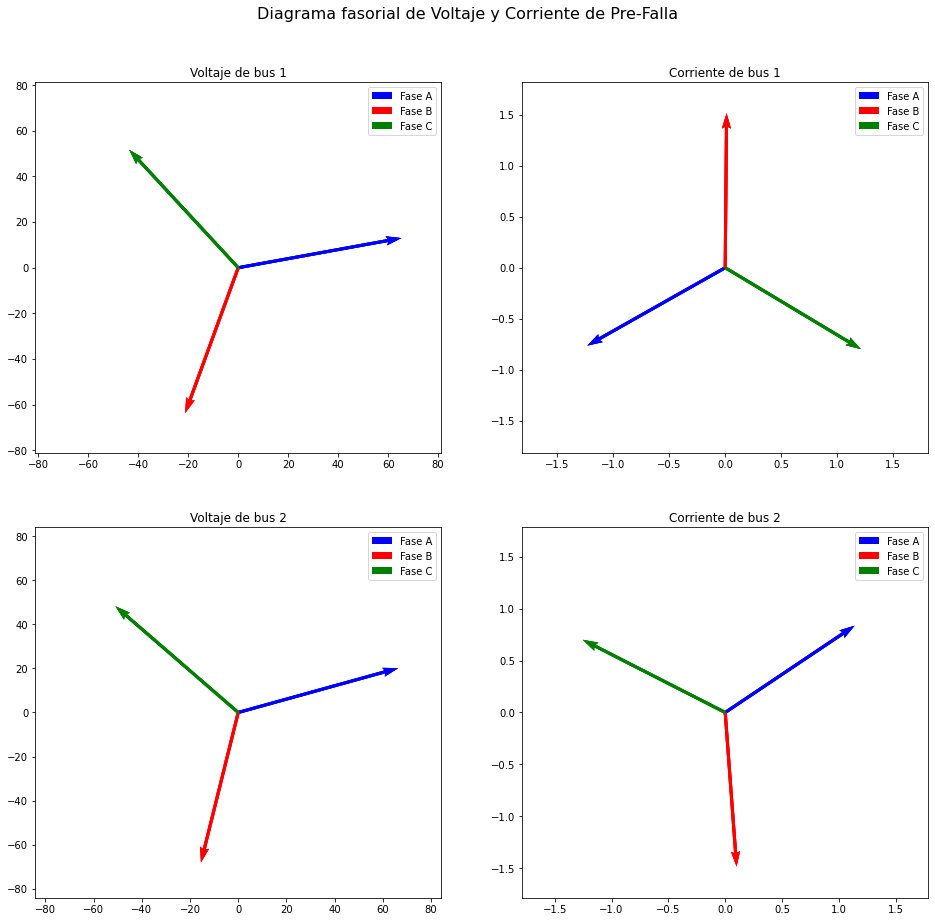

In [13]:
# Creando la figura
f, axarr = plt.subplots(2, 2, figsize =(16, 15))
f.suptitle('Diagrama fasorial de Voltaje y Corriente de Pre-Falla', y=0.95, fontsize=16)

#lim_axis_V = np.max([np.float(X_V[-1:,0]), np.float(X_V[-1:,1]),np.float(X_V[-1:,2])])
#lim_axis_C = np.max([np.float(X_C[-1:,0]), np.float(X_C[-1:,1]),np.float(X_C[-1:,2])])
#print(lim_axis_V)
# Creando el punto de origen para los vectores
x_pos = [0, 0,0] 
y_pos = [0, 0,0]

n_bus=1
for i in range(len(measures_Xc)):    
    #print(lim_axis_V)
    if (i % 2)==0: #Si es par
        p1 = np.int(i/2)
        p2 = 0
        axarr[p1,p2].set_title(('Voltaje de bus '+str(n_bus)))
        lim_axis_V = np.max([np.float(measures_X[i][0,0]), np.float(measures_X[i][0,1]),np.float(measures_X[i][0,2])])
        axarr[p1,p2].axis([-1.2*lim_axis_V, 1.2*lim_axis_V, -1.2*lim_axis_V, 1.2*lim_axis_V]) 
    else:
        p1 = np.int(np.ceil(i/2)-1)
        p2 = 1
        axarr[p1,p2].set_title(('Corriente de bus '+str(n_bus)))
        lim_axis_C = np.max([np.float(measures_X[i][0,0]), np.float(measures_X[i][0,1]),np.float(measures_X[i][0,2])])
        axarr[p1,p2].axis([-1.2*lim_axis_C, 1.2*lim_axis_C, -1.2*lim_axis_C, 1.2*lim_axis_C]) 
        n_bus=n_bus+1
        
    axarr[p1,p2].quiver(x_pos, y_pos, measures_Xc[i][0,0], measures_Xs[i][0,0], angles='xy', scale_units = 'xy', scale=1, color=['b'], label='Fase A') 
    axarr[p1,p2].quiver(x_pos, y_pos, measures_Xc[i][0,1], measures_Xs[i][0,1], angles='xy', scale_units = 'xy', scale=1, color=['r'], label='Fase B')
    axarr[p1,p2].quiver(x_pos, y_pos, measures_Xc[i][0,2], measures_Xs[i][0,2], angles='xy', scale_units = 'xy', scale=1, color=['g'], label='Fase C') 
    axarr[p1,p2].legend()


FALLA

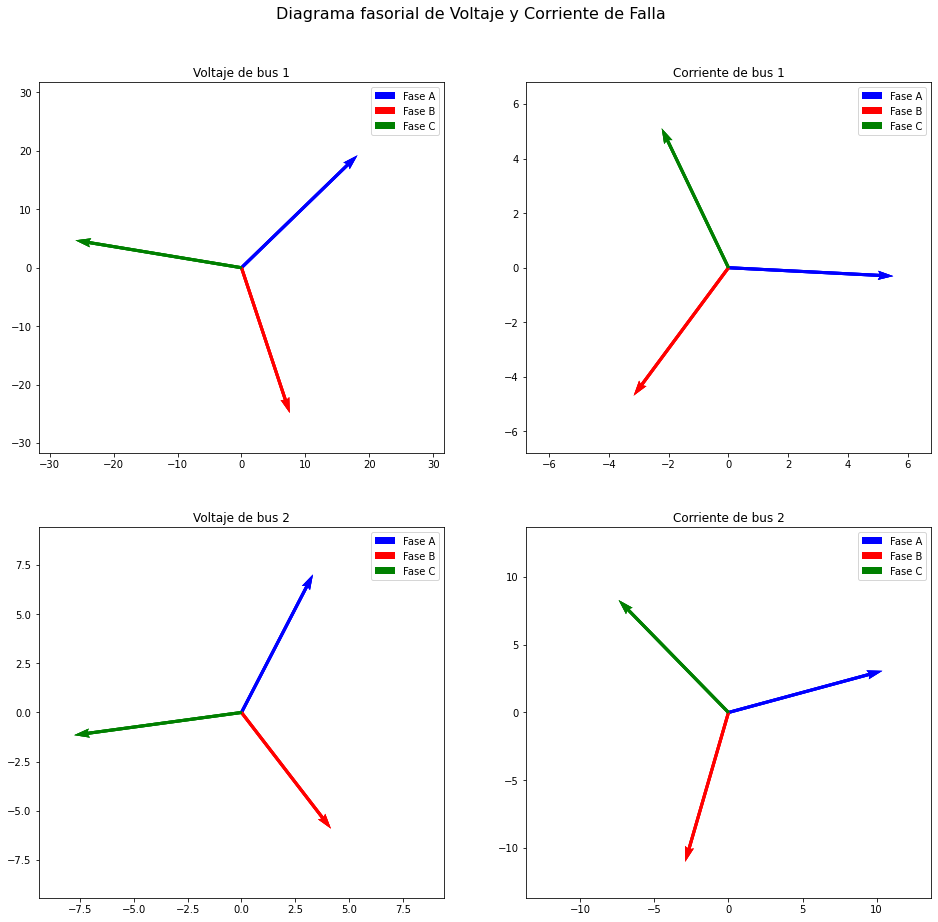

In [14]:
# Creando la figura
f, axarr = plt.subplots(2, 2, figsize =(16, 15))
f.suptitle('Diagrama fasorial de Voltaje y Corriente de Falla', y=0.95, fontsize=16)

#lim_axis_V = np.max([np.float(X_V[-1:,0]), np.float(X_V[-1:,1]),np.float(X_V[-1:,2])])
#lim_axis_C = np.max([np.float(X_C[-1:,0]), np.float(X_C[-1:,1]),np.float(X_C[-1:,2])])
#print(lim_axis_V)
# Creando el punto de origen para los vectores
x_pos = [0, 0,0] 
y_pos = [0, 0,0]

n_bus=1
for i in range(len(measures_Xc)):    
    #print(lim_axis_V)
    if (i % 2)==0: #Si es par
        p1 = np.int(i/2)
        p2 = 0
        axarr[p1,p2].set_title(('Voltaje de bus '+str(n_bus)))
        lim_axis_V = np.max([np.float(measures_X[i][pos_tf,0]), np.float(measures_X[i][pos_tf,1]),np.float(measures_X[i][pos_tf,2])])
        axarr[p1,p2].axis([-1.2*lim_axis_V, 1.2*lim_axis_V, -1.2*lim_axis_V, 1.2*lim_axis_V]) 
    else:
        p1 = np.int(np.ceil(i/2)-1)
        p2 = 1
        axarr[p1,p2].set_title(('Corriente de bus '+str(n_bus)))
        lim_axis_C = np.max([np.float(measures_X[i][pos_tf,0]), np.float(measures_X[i][pos_tf,1]),np.float(measures_X[i][pos_tf,2])])
        axarr[p1,p2].axis([-1.2*lim_axis_C, 1.2*lim_axis_C, -1.2*lim_axis_C, 1.2*lim_axis_C]) 
        n_bus=n_bus+1
        
    axarr[p1,p2].quiver(x_pos, y_pos, measures_Xc[i][pos_tf,0], measures_Xs[i][pos_tf,0], angles='xy', scale_units = 'xy', scale=1, color=['b'], label='Fase A') 
    axarr[p1,p2].quiver(x_pos, y_pos, measures_Xc[i][pos_tf,1], measures_Xs[i][pos_tf,1], angles='xy', scale_units = 'xy', scale=1, color=['r'], label='Fase B')
    axarr[p1,p2].quiver(x_pos, y_pos, measures_Xc[i][pos_tf,2], measures_Xs[i][pos_tf,2], angles='xy', scale_units = 'xy', scale=1, color=['g'], label='Fase C') 
    axarr[p1,p2].legend()
 

## Calculo de Componentes simétricas

Se crean tres funciones para la generación de las secuencias y el cálculo de cada componente de cada fase.

In [15]:
def seq_general(ph):
    # Se usan las fases en valores rectangulares
    phA = ph[0]
    phB = ph[1]
    phC = ph[2]
    a = -0.5 + (np.sqrt(3)/2)*1j
    s0=(phA+phB+phC)/3
    s1=(phA+a*phB+a*a*phC)/3
    s2=(phA+a*a*phB+a*phC)/3
    #s = [s0, s1, s2]
    return s0, s1, s2

def seq_pos(s1):
    a = -0.5 + (np.sqrt(3)/2)*1j
    phA1 = s1
    phB1 = a*a*s1
    phC1 = a*s1
    ph = [phA1, phB1, phC1]
    return ph
    
def seq_neg(s2):
    a = -0.5 + (np.sqrt(3)/2)*1j
    phA2 = s2
    phB2 = a*s2
    phC2 = a*a*s2
    ph = [phA2, phB2, phC2]
    return ph


In [16]:
ph_pre = np.empty(([2,6]), dtype=complex)
ph_falla = np.empty(([2,6]), dtype=complex)
ph = ['A','B','C']
for b in range(2):
    for i in range(len(ph)):
        if b==0:
            ph_pre[b,i] = complex(Xc_bus1_V[0,i],Xs_bus1_V[0,i])
            ph_pre[b,i+3] = complex(Xc_bus1_I[0,i],Xs_bus1_I[0,i])
            ph_falla[b,i] = complex(Xc_bus1_V[pos_tf,i],Xs_bus1_V[pos_tf,i])
            ph_falla[b,i+3] = complex(Xc_bus1_I[pos_tf,i],Xs_bus1_I[pos_tf,i])
        else:
            ph_pre[b,i] = complex(Xc_bus2_V[0,i],Xs_bus2_V[0,i])
            ph_pre[b,i+3] = complex(Xc_bus2_I[0,i],Xs_bus2_I[0,i])
            ph_falla[b,i] = complex(Xc_bus2_V[pos_tf,i],Xs_bus2_V[pos_tf,i])
            ph_falla[b,i+3] = complex(Xc_bus2_I[pos_tf,i],Xs_bus2_I[pos_tf,i])

A continuación, se grafican los diagramas de fase y se secuencia para un instante pre-falla y un instante de falla en los dos buses terminales de la línea.

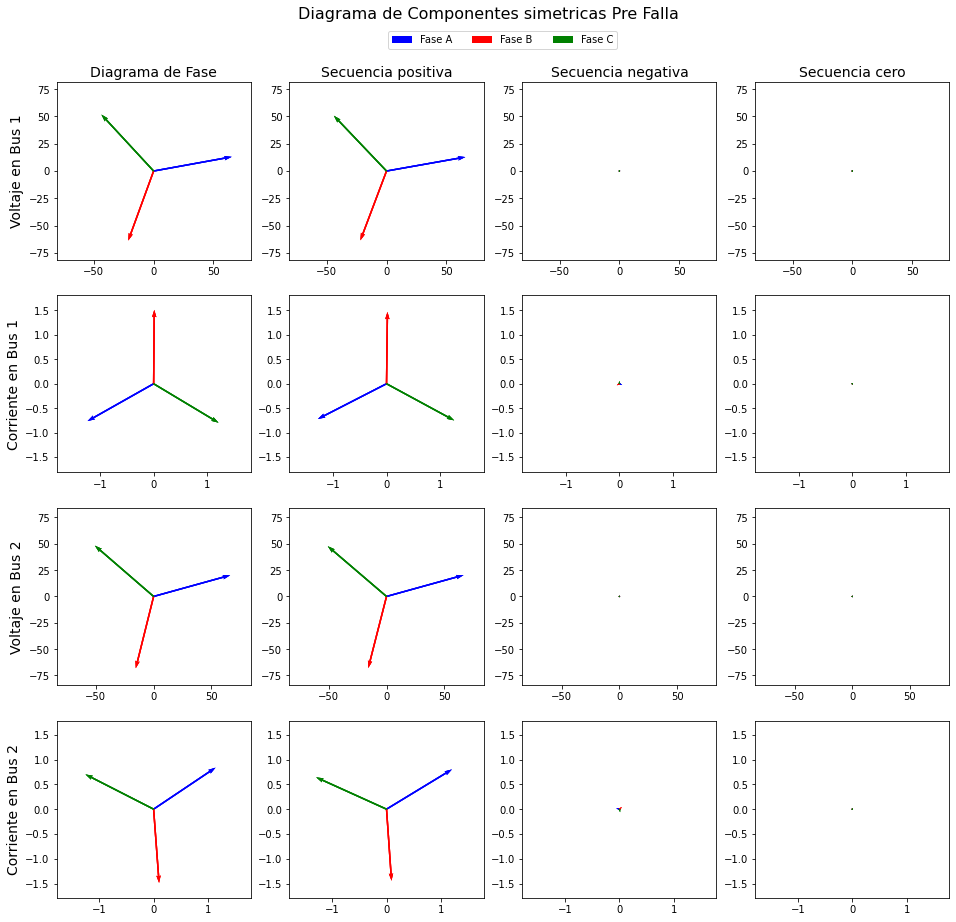

In [17]:
# Calculo de secuencias de  prefalla
V_seq_pre = np.empty(([6,4]), dtype=complex)
c = 0
for i in range(2):
    for j in range(3):
        V_seq_pre[c,0] =  ph_pre[i,j]
        c = c +1
    s0,s1,s2 = seq_general(V_seq_pre[i*3:i*3+3,0])
    V_seq_pre[i*3:i*3+3,1] = seq_pos(s1)
    V_seq_pre[i*3:i*3+3,2] = seq_pos(s2)
    V_seq_pre[i*3:i*3+3,3] = [s0,s0,s0]
    
I_seq_pre = np.empty(([6,4]), dtype=complex)
c = 0
for i in range(2):
    for j in range(3):
        I_seq_pre[c,0] =  ph_pre[i,j+3]
        c = c + 1
    s0,s1,s2 = seq_general(I_seq_pre[i*3:i*3+3,0])
    I_seq_pre[i*3:i*3+3,1] = seq_pos(s1)
    I_seq_pre[i*3:i*3+3,2] = seq_pos(s2)
    I_seq_pre[i*3:i*3+3,3] = [s0,s0,s0]

# Creando la figura
f, axarr = plt.subplots(4, 4, figsize =(16, 15))
f.suptitle('Diagrama de Componentes simetricas Pre Falla', y=0.95, fontsize=16)
# Creando el punto de origen para los vectores

x_pos = [0, 0,0] 
y_pos = [0, 0,0]
cont1 = 0
cont2 = 0
label = ['Fase A', 'Fase B', 'Fase C']
colors = ['b','r','g']
n=0
n1=0
for i in range(4):
    for k in range(3):
        if (i%2)==0:
            lim_axis_V = np.max([np.float(abs(V_seq_pre[0+3*n,0])), np.float(abs(V_seq_pre[1+3*n,0])),np.float(abs(V_seq_pre[2+3*n,0]))])
            axarr[i,0].quiver(x_pos, y_pos, V_seq_pre[cont1,0].real , V_seq_pre[cont1,0].imag, angles='xy', scale_units = 'xy', scale=1, color=colors[k], label=label[k])
            axarr[i,1].quiver(x_pos, y_pos, V_seq_pre[cont1,1].real , V_seq_pre[cont1,1].imag, angles='xy', scale_units = 'xy', scale=1, color=colors[k], label=label[k])
            axarr[i,2].quiver(x_pos, y_pos, V_seq_pre[cont1,2].real , V_seq_pre[cont1,2].imag, angles='xy', scale_units = 'xy', scale=1, color=colors[k], label=label[k])
            axarr[i,3].quiver(x_pos, y_pos, V_seq_pre[cont1,3].real , V_seq_pre[cont1,3].imag, angles='xy', scale_units = 'xy', scale=1, color=colors[k], label=label[k])
            axarr[i,0].axis([-1.2*lim_axis_V, 1.2*lim_axis_V, -1.2*lim_axis_V, 1.2*lim_axis_V])
            axarr[i,1].axis([-1.2*lim_axis_V, 1.2*lim_axis_V, -1.2*lim_axis_V, 1.2*lim_axis_V])
            axarr[i,2].axis([-1.2*lim_axis_V, 1.2*lim_axis_V, -1.2*lim_axis_V, 1.2*lim_axis_V])
            axarr[i,3].axis([-1.2*lim_axis_V, 1.2*lim_axis_V, -1.2*lim_axis_V, 1.2*lim_axis_V])
            if i==0:
                if cont1 < 3: cont1 = cont1+1
                else: cont1=0
            else:
                n = 1
                if cont1 < 6: cont1 = cont1 + 1
                else: cont1 = 3                    
        else:
            lim_axis_I = np.max([np.float(abs(I_seq_pre[0+3*n1,0])), np.float(abs(I_seq_pre[1+3*n1,0])),np.float(abs(I_seq_pre[2+3*n1,0]))])
            axarr[i,0].quiver(x_pos, y_pos, I_seq_pre[cont2,0].real , I_seq_pre[cont2,0].imag, angles='xy', scale_units = 'xy', scale=1, color=colors[k], label=label[k])
            axarr[i,1].quiver(x_pos, y_pos, I_seq_pre[cont2,1].real , I_seq_pre[cont2,1].imag, angles='xy', scale_units = 'xy', scale=1, color=colors[k], label=label[k])
            axarr[i,2].quiver(x_pos, y_pos, I_seq_pre[cont2,2].real , I_seq_pre[cont2,2].imag, angles='xy', scale_units = 'xy', scale=1, color=colors[k], label=label[k])
            axarr[i,3].quiver(x_pos, y_pos, I_seq_pre[cont2,3].real , I_seq_pre[cont2,3].imag, angles='xy', scale_units = 'xy', scale=1, color=colors[k], label=label[k])
            axarr[i,0].axis([-1.2*lim_axis_I, 1.2*lim_axis_I, -1.2*lim_axis_I, 1.2*lim_axis_I])
            axarr[i,1].axis([-1.2*lim_axis_I, 1.2*lim_axis_I, -1.2*lim_axis_I, 1.2*lim_axis_I])
            axarr[i,2].axis([-1.2*lim_axis_I, 1.2*lim_axis_I, -1.2*lim_axis_I, 1.2*lim_axis_I])
            axarr[i,3].axis([-1.2*lim_axis_I, 1.2*lim_axis_I, -1.2*lim_axis_I, 1.2*lim_axis_I])
            if i==1:
                if cont2 < 3: cont2 = cont2+1
                else: cont2=0
            else:
                n1 = 1
                if cont2 < 6: cont2 = cont2 + 1
                else: cont2 = 3  
            
axarr[0,0].set_ylabel('Voltaje en Bus 1',fontsize=14)
axarr[1,0].set_ylabel('Corriente en Bus 1',fontsize=14)
axarr[2,0].set_ylabel('Voltaje en Bus 2',fontsize=14)
axarr[3,0].set_ylabel('Corriente en Bus 2',fontsize=14)
axarr[0,0].set_title('Diagrama de Fase',fontsize=14)
axarr[0,1].set_title('Secuencia positiva',fontsize=14)
axarr[0,2].set_title('Secuencia negativa',fontsize=14)
axarr[0,3].set_title('Secuencia cero',fontsize=14)

f.legend(axarr[0,0].get_children(), label, ncol=5, bbox_to_anchor=(0.54, 0.83))

Ahora se presentan los gráficos para un instante de falla en los dos buses terminales del sistema.

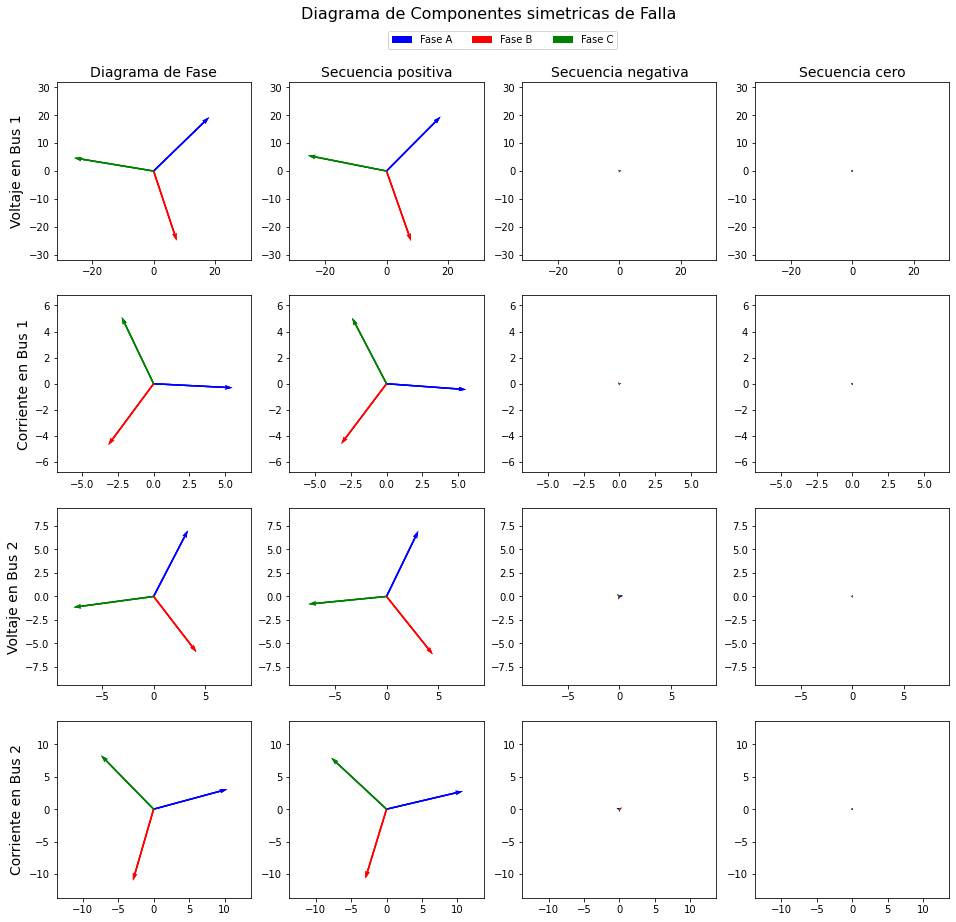

In [18]:
# Calculo de secuencias de  falla
V_seq_falla = np.empty(([6,4]), dtype=complex)
c = 0
for i in range(2):
    for j in range(3):
        V_seq_falla[c,0] =  ph_falla[i,j]
        c = c +1
    s0,s1,s2 = seq_general(V_seq_falla[i*3:i*3+3,0])
    V_seq_falla[i*3:i*3+3,1] = seq_pos(s1)
    V_seq_falla[i*3:i*3+3,2] = seq_pos(s2)
    V_seq_falla[i*3:i*3+3,3] = [s0,s0,s0]
    
I_seq_falla = np.empty(([6,4]), dtype=complex)
c = 0
for i in range(2):
    for j in range(3):
        I_seq_falla[c,0] =  ph_falla[i,j+3]
        c = c + 1
    s0,s1,s2 = seq_general(I_seq_falla[i*3:i*3+3,0])
    I_seq_falla[i*3:i*3+3,1] = seq_pos(s1)
    I_seq_falla[i*3:i*3+3,2] = seq_pos(s2)
    I_seq_falla[i*3:i*3+3,3] = [s0,s0,s0]

# Creando la figura
f, axarr = plt.subplots(4, 4, figsize =(16, 15))
f.suptitle('Diagrama de Componentes simetricas de Falla', y=0.95, fontsize=16)
# Creando el punto de origen para los vectores

x_pos = [0, 0,0] 
y_pos = [0, 0,0]
cont1 = 0
cont2 = 0
label = ['Fase A', 'Fase B', 'Fase C']
colors = ['b','r','g']
n=0
n1=0
for i in range(4):
    for k in range(3):
        if (i%2)==0:
            lim_axis_V = np.max([np.float(abs(V_seq_falla[0+3*n,0])), np.float(abs(V_seq_falla[1+3*n,0])),np.float(abs(V_seq_falla[2+3*n,0]))])
            axarr[i,0].quiver(x_pos, y_pos, V_seq_falla[cont1,0].real , V_seq_falla[cont1,0].imag, angles='xy', scale_units = 'xy', scale=1, color=colors[k], label=label[k])
            axarr[i,1].quiver(x_pos, y_pos, V_seq_falla[cont1,1].real , V_seq_falla[cont1,1].imag, angles='xy', scale_units = 'xy', scale=1, color=colors[k], label=label[k])
            axarr[i,2].quiver(x_pos, y_pos, V_seq_falla[cont1,2].real , V_seq_falla[cont1,2].imag, angles='xy', scale_units = 'xy', scale=1, color=colors[k], label=label[k])
            axarr[i,3].quiver(x_pos, y_pos, V_seq_falla[cont1,3].real , V_seq_falla[cont1,3].imag, angles='xy', scale_units = 'xy', scale=1, color=colors[k], label=label[k])
            axarr[i,0].axis([-1.2*lim_axis_V, 1.2*lim_axis_V, -1.2*lim_axis_V, 1.2*lim_axis_V])
            axarr[i,1].axis([-1.2*lim_axis_V, 1.2*lim_axis_V, -1.2*lim_axis_V, 1.2*lim_axis_V])
            axarr[i,2].axis([-1.2*lim_axis_V, 1.2*lim_axis_V, -1.2*lim_axis_V, 1.2*lim_axis_V])
            axarr[i,3].axis([-1.2*lim_axis_V, 1.2*lim_axis_V, -1.2*lim_axis_V, 1.2*lim_axis_V])
            if i==0:
                if cont1 < 3: cont1 = cont1+1
                else: cont1=0
            else:
                n=1
                if cont1 < 6: cont1 = cont1 + 1
                else: cont1 = 3                    
        else:
            lim_axis_I = np.max([np.float(abs(I_seq_falla[0+3*n1,0])), np.float(abs(I_seq_falla[1+3*n1,0])),np.float(abs(I_seq_falla[2+3*n1,0]))])
            axarr[i,0].quiver(x_pos, y_pos, I_seq_falla[cont2,0].real , I_seq_falla[cont2,0].imag, angles='xy', scale_units = 'xy', scale=1, color=colors[k], label=label[k])
            axarr[i,1].quiver(x_pos, y_pos, I_seq_falla[cont2,1].real , I_seq_falla[cont2,1].imag, angles='xy', scale_units = 'xy', scale=1, color=colors[k], label=label[k])
            axarr[i,2].quiver(x_pos, y_pos, I_seq_falla[cont2,2].real , I_seq_falla[cont2,2].imag, angles='xy', scale_units = 'xy', scale=1, color=colors[k], label=label[k])
            axarr[i,3].quiver(x_pos, y_pos, I_seq_falla[cont2,3].real , I_seq_falla[cont2,3].imag, angles='xy', scale_units = 'xy', scale=1, color=colors[k], label=label[k])
            axarr[i,0].axis([-1.2*lim_axis_I, 1.2*lim_axis_I, -1.2*lim_axis_I, 1.2*lim_axis_I])
            axarr[i,1].axis([-1.2*lim_axis_I, 1.2*lim_axis_I, -1.2*lim_axis_I, 1.2*lim_axis_I])
            axarr[i,2].axis([-1.2*lim_axis_I, 1.2*lim_axis_I, -1.2*lim_axis_I, 1.2*lim_axis_I])
            axarr[i,3].axis([-1.2*lim_axis_I, 1.2*lim_axis_I, -1.2*lim_axis_I, 1.2*lim_axis_I])
            if i==1:
                if cont2 < 3: cont2 = cont2+1
                else: cont2=0
            else:
                n1=1
                if cont2 < 6: cont2 = cont2 + 1
                else: cont2 = 3  
            
axarr[0,0].set_ylabel('Voltaje en Bus 1',fontsize=14)
axarr[1,0].set_ylabel('Corriente en Bus 1',fontsize=14)
axarr[2,0].set_ylabel('Voltaje en Bus 2',fontsize=14)
axarr[3,0].set_ylabel('Corriente en Bus 2',fontsize=14)
axarr[0,0].set_title('Diagrama de Fase',fontsize=14)
axarr[0,1].set_title('Secuencia positiva',fontsize=14)
axarr[0,2].set_title('Secuencia negativa',fontsize=14)
axarr[0,3].set_title('Secuencia cero',fontsize=14)

f.legend(axarr[0,0].get_children(), label, ncol=5, bbox_to_anchor=(0.54, 0.83))

# Relé de distancia: Función 21

En esta sección se definen los pasos seguidos para la implementación de la función 21 de distancia en el relé para la protección de la línea.

## Detección de la Falla

Se usa un modelo de componentes simetricas para la detección de la falla. En este caso se usa la fase de las componentes simetricas de la corriente medidas en el bus uno. La comparación entre la fase de la secuencia negativa y positiva permitirá detectar las fallas involucradas a tierra y las fallas bifásicas; mientras que la comparación de fases entre la secuencia negativa y cero permitirá detectar las fallas a tierra.

A continuación se define la función que compara las fases de la secuencia positiva y la secuencia negativa.

In [19]:
# se crea las etiquetas para la comparación entre positiva y negativa
def pos_neg():
    etiqueta_pos_neg = [{'AG'},{'AB','ABG'},{'BG'},{'BC','BCG'},{'CG'},{'AC','ACG'}]

    grupos_pos_neg = [set()]*12
    fallas_pos_neg = np.empty(([12,2]))
    c = 0
    for i in range(len(fallas_pos_neg)):
        if (i%2)==0:
            grupos_pos_neg[i] = etiqueta_pos_neg[c] 
            if i==0:
                fallas_pos_neg[i,0:2] = [340,20]
            else:
                fallas_pos_neg[i,0:2] = [fallas_pos_neg[i-1,1],fallas_pos_neg[i-1,1]+40]
            c=c+1
        else:
            fallas_pos_neg[i,0:2] = [fallas_pos_neg[i-1,1],fallas_pos_neg[i-1,1]+20]
            if c<len(etiqueta_pos_neg):
                grupos_pos_neg[i] = etiqueta_pos_neg[c].union(grupos_pos_neg[i-1])
            else:
                grupos_pos_neg[i] = grupos_pos_neg[i-1].union(etiqueta_pos_neg[0])
    return grupos_pos_neg, fallas_pos_neg

A continuación se presenta la función que define la falla considerando las fases de secuencia negativa y cero.

In [20]:
# se crea las etiquetas para la comparación entre cero y negativa 
def cero_neg():
    etiqueta_cero_neg = [{'AG','BCG'},{'CG','ABG'},{'BG','ACG'}]

    grupos_cero_neg = [set()]*6
    fallas_cero_neg = np.empty(([6,2]))
    c = 0
    for i in range(len(fallas_cero_neg)):
        if (i%2)==0:
            grupos_cero_neg[i] = etiqueta_cero_neg[c] 
            if i==0:
                fallas_cero_neg[i,0:2] = [315,45]
            else:
                fallas_cero_neg[i,0:2] = [fallas_cero_neg[i-1,1],fallas_cero_neg[i-1,1]+90]
            c=c+1
        else:
            fallas_cero_neg[i,0:2] = [fallas_cero_neg[i-1,1],fallas_cero_neg[i-1,1]+30]
            if c<len(etiqueta_cero_neg):
                grupos_cero_neg[i] = etiqueta_cero_neg[c].union(grupos_cero_neg[i-1])
            else:
                grupos_cero_neg[i] = grupos_cero_neg[i-1].union(etiqueta_cero_neg[0])
    return grupos_cero_neg, fallas_cero_neg

Se crea una función que recibe las componentes simetricas de corriente en coordenadas rectagulares y señala el tipo de falla detectado con las condiciones dadas.

In [21]:
def tipo_falla(s0,s1,s2):
    r0, th0 = cmath.polar(s0)
    r1, th1 = cmath.polar(s1)
    r2, th2 = cmath.polar(s2)
    
    grupos_pos_neg, fallas_pos_neg = pos_neg()
    grupos_cero_neg, fallas_cero_neg = cero_neg()
    if r2 < 0.25:
        type_f={'ABC'}
    else:
        if r0 > 0.02:
            grupo_mo = {'AG','BG','CG'}
            # Verificación cero-negativa
            th2_off = th2 - th0
            th0_off = th0 - th0
            des0 = (th2_off - th0_off)*180/np.pi
            if des0<0: des0 = 360+des0
            for i in range(len(fallas_cero_neg)):
                if des0>340 or des0<=20:
                    sel1=grupos_cero_neg[0]
                elif i!=0 and des0>fallas_cero_neg[i,0] and des0<=fallas_cero_neg[i,1]:
                    sel1=grupos_cero_neg[i]
            # Verificacion positiva-negativa
            th2_off = th2 - th1
            th1_off = th1 - th1
            des1 = (th2_off-th1_off)*180/np.pi
            if des1<0: des1 = 360+des1
            for i in range(len(fallas_pos_neg)):
                if des1>340 or des1<=20:
                    sel2=grupos_pos_neg[0]
                elif i!=0 and des1>fallas_pos_neg[i,0] and des1<=fallas_pos_neg[i,1]:
                    sel2=grupos_pos_neg[i]
            type_f = sel1.intersection(sel2)
            if type_f == set():
                type_f = sel1.intersection(grupo_mo)
        else:
            grupo_bi = {'AB','BC','AC'}
            th2_off = th2 - th1
            th1_off = th1 - th1
            des1 = (th2_off-th1_off)*180/np.pi
            if des1<0: des1 = 360+des1
            for i in range(len(fallas_pos_neg)):
                if des1>340 or des1<=20:
                    sel=(grupos_pos_neg[0])
                elif i!=0 and des1>fallas_pos_neg[i,0] and des1<=fallas_pos_neg[i,1]:
                    sel=(grupos_pos_neg[i])
            type_f = sel.intersection(grupo_bi)
    return type_f

A continuación se utiliza la función anterior para realizar la detección de la falla. Adicionalmente se definen las variables que manejarán los voltajes y corrientes utilizados para el cálculo de la impedancia.

In [22]:
# Detección del tipo de falla
ph_I = ph_falla[0,3:6]
s0_I,s1_I,s2_I = seq_general(ph_I)
print(abs(s2_I))
tipo = tipo_falla(s0_I,s1_I,s2_I)

#Calculo de voltaje de secuencia
ph_V = ph_falla[0,0:3]
s0_V,s1_V,s2_V = seq_general(ph_V)

#voltaje y corriente de fase
Va,Vb,Vc = ph_falla[0,0:3]
Ia,Ib,Ic = ph_falla[0,3:6]

0.13192849958331054


## Cálculo de impedancia

Esta sección presenta el cálculo de la impedancia teniendo en cuenta el tipo de falla detecta. Teniendo en cuenta el tipo de falla detectada usará las siguientes ecuaciones. Es importante resaltar que todas las impedancias están referidas al lado primario de los transformadores de instrumentación, por tanto los voltajes y corrientes son multiplicados por la relación de PT y CT, respectivamente.

- Falla trífásica

$Z_f=\frac{V_1}{I_1} $

Donde $V_1$ es el voltaje de secuencia positiva e $I_1$ es la corriente de secuencia negativa.
- Falla bifásica

$Z_f = \frac{V_{f1}-V_{f2}}{I_{f1}-I_{f2}}$

Donde $V_{f1}$ y $V_{f2}$ son los voltajes de las fases falladas, $I_{f1}$ e $I_{f2}$ son las corrientes de las fases falladas.

- Falla monofásica

$Z_f = \frac{V_{f}}{I_{f}K_0 I_R + k_{0M}I_{0M}}$

Donde $V_f$ e $I_f$ son el voltaje y la corriente de falla, respectivamente. $k_0 = \frac{Z_{0L}-Z_{1L}}{3Z_{1L}}$, $Z_{0M}$ es la impedancia de acople mutuo de secuencia cero entre las dos línes e $I_{0M}$ es la corriente de secuencia cero de acople entre las líneas.


In [23]:
def default():
    return 'No es ninguna'

def ABC(s1_V,s1_I):
    return (s1_V/s1_I)*(ratio_PT/ratio_CT)

def LL(v1,v2,i1,i2):
    return ((v1-v2)/(i1-i2))*(ratio_PT/ratio_CT)

def LG(v,i,k0,s0_I,k0m):
    z = v/(i+k0*3*s0_I+k0m*s0_I)*3
    return z
    
def switch(case,s0_V,s1_V,s2_V,s0_I,s1_I,s2_I,Va,Vb,Vc,Ia,Ib,Ic,k0,k0m):
   sw = {1:ABC(s1_V,s1_I),
         2:LG(Va,Ia,k0,s0_I,k0m),
         3:LG(Vb,Ib,k0,s0_I,k0m),
         4:LG(Vc,Ic,k0,s0_I,k0m),
         5:LL(Va,Vb,Ia,Ib),
         6:LL(Vb,Vc,Ib,Ic),
         7:LL(Va,Vc,Ia,Ic),
         8:LL(Va,Vb,Ia,Ib),
         9:LL(Vb,Vc,Ib,Ic),
         10:LL(Va,Vc,Ia,Ic), 
        }
   return sw.get(case, default())

A continuación se calcula la impedancia teniendo en cuenta la detección de la falla

In [24]:
# Datos y cálculos adicionales
Z1L = complex(R1L*L, X1L*L)
Z0L = complex(R0L*L, X0L*L)
Z0M = complex(R0M*L,X0M*L)

k0 = (Z0L-Z1L)/(3*Z1L)
k0m = Z0M/Z1L

# Se crea el conjunto de fallas
tipos_fallas = [{'ABC'},{'AG'},{'BG'},{'CG'},{'ABG'},{'BCG'},{'ACG'},{'AB'},{'BC'},{'AC'}]

imp = 0
for i in range(len(tipos_fallas)):
    if tipo == tipos_fallas[i]:
        imp = switch(i+1,s0_V,s1_V,s2_V,s0_I,s1_I,s2_I,Va,Vb,Vc,Ia,Ib,Ic,k0,k0m)

## Diagrama de impedancia Mho

En el diagrama de la característica Mho se muestra la definición de las zonas dadas por el usuario, un vector que representa la posición y recorrido de la impedancia de línea y el punto en el que se ubica la impedancia calculada previamente para definir la activación de la función 21.

In [25]:
def zones_plot(Z1L, zone1, zone2, Z):
    r_1L, th_1L = cmath.polar(Z1L*zone1)
    r , th = cmath.polar(Z)
    fig, ax = plt.subplots(1, 1, figsize =(6, 6))
    fig.suptitle('Diagrama de impedancia para relé de característica Mho', y=0.95, fontsize=16)
    
    r1=r_1L
    r_1L, th_1L = cmath.polar(Z1L*zone2)
    r2=r_1L
    
    # Creando el punto de origen para los vectores
    x_pos = [0, 0,0] 
    y_pos = [0, 0,0]
    
    x_Z1L = Z1L.real
    y_Z1L = Z1L.imag
    
    x_Z = Z.real
    y_Z = Z.imag
    
    if r1 > abs(Z):
        r_lim = r1
    else: r_lim = abs(Z)
    
    ax.set(xlim=(-r_lim, r_lim*2), ylim = (-r_lim, r_lim*2))

    a_circle = plt.Circle((x_Z1L*zone1/2, y_Z1L*zone1/2), r1/2, fill = False, linestyle= '--', edgecolor = 'r')
    ax.add_artist(a_circle)
    
    a_circle2 = plt.Circle((x_Z1L*zone2/2, y_Z1L*zone2/2), r2/2, fill = False, linestyle= '--', edgecolor = 'g')
    ax.add_artist(a_circle2)
    
    ax.quiver(x_pos, y_pos, x_Z1L, y_Z1L, angles='xy', scale_units = 'xy', scale=1, color=['k'], label=r'$Z_{Line}$')
    #ax.quiver(x_pos, y_pos, x_Z, y_Z, angles='xy', scale_units = 'xy', scale=1, color=['b'], label=r'$\bar{Z}$')
    ax.plot(x_Z, y_Z, 'b*', label=r'$\bar{Z}$')
    
    plt.text(-r_1L/10, r_1L*zone1+r_1L/10, r'$Z_1$', {'color': 'red', 'fontsize': 12}, rotation=0, horizontalalignment='center', verticalalignment='top',
         multialignment='center')
    plt.text(-r_1L/10, r_1L*zone2+r_1L/10, r'$Z_2$', {'color': 'green', 'fontsize': 12}, rotation=0, horizontalalignment='center', verticalalignment='top',
         multialignment='center')
    
    #Create broken lines
    x=np.linspace(start=-r_lim*2,stop=r_lim*2,num=30)
    plt.scatter(x,[0]*len(x), marker='_',color='k')
    plt.scatter([0]*len(x), x, marker='|',color='k')
    
    plt.xlabel('R')
    plt.ylabel('X')
    plt.legend()
    plt.show

Se muestra la gráfica, permitiendo visualizar el punto en el que se encuentra la impedancia.

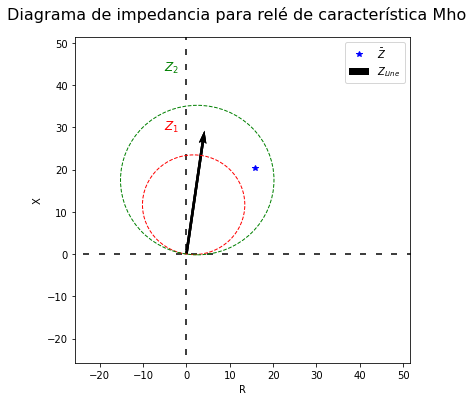

In [26]:
#print(phase(Z))
zones_plot(Z1L, zone1, zone2, imp)

Se calcula distancia de falla teniendo en cuenta la impedancia calculada.

In [27]:
print('La impedancia está al {:.2f}% de la longitud de la línea'.format(abs(imp)/abs(Z1L)*100))
dist = abs(imp)/abs(Z1L)*100

La impedancia está al 87.26% de la longitud de la línea


Se verifican los límites de cada zona y se decide si la impedancia cálculada está en alguna de las zonas o se encuentra fuera de las zonas.

In [28]:
ciclo = 1/fk
activa = 0
if (imp.real*imp.real - imp.real*Z1L.real*zone1)<(imp.imag*Z1L.imag*zone1-imp.imag*imp.imag):
    print('Dipare zona 1')
    zona = 'Zona 1'
    pos_tz=1
    activa=1
elif (imp.real*imp.real-imp.real*Z1L.real*zone2)<(imp.imag*Z1L.imag*zone2-imp.imag*imp.imag):
    print('Dispare zona 2')
    pos_tz=(t2/ciclo)*fs_user_cycle
    zona = 'Zona 2'
    activa=1
else:
    print('No se activa')
    activo=0

Dispare zona 2


## Gráficas

In [29]:
def graf_21():
    deteccion = np.empty(([N_tot_DFT,1]))
    disparo = np.empty(([N_tot_DFT,1]))
    for i in range(len(deteccion)):
        if i>=pos_tf1:
            deteccion[i] = 1
            if i>=pos_tf1+pos_tz:
                if activa==1:
                    disparo[i]=1
                    deteccion[i]=0
                else: disparo[i]=0            
            else:

                disparo[i]=0
        else:
            deteccion[i] = 0
            disparo[i] = 0

    fig = plt.subplots(1, 1, figsize =(9, 5))
    plt.plot(t[:,0],deteccion,'b--', label = 'Detección de Falla')
    plt.plot(t[:,0],disparo,'r--', label='Señal de disparo')
    plt.legend()
    plt.title('Señales Digitales', fontsize=16)
    plt.xlabel('Tiempo (seg)')
    plt.ylabel('Dato binario')
    plt.show()

# Reporte del evento de Falla

In [30]:
def results_21():
    titulo =['Función', 'Zona','Tipo Falla','Detección [seg]', 'Disparo [seg]','Distancia [%]']
    results = {'Función': 'Distancia (21)',
               'Zona': zona,
               'Tipo Falla': tipo,
               'Detección [seg]':t[np.int(pos_tf1),0],
               'Disparo [seg]':t[np.int(pos_tf1+pos_tz),0],
               'Distancia [%]':'{:.2f}'.format(dist)}
    r = pd.DataFrame(results,columns=titulo)
    return r

# Relé de Sobrecorriente Temporizada Normalmente Inversa (51)

Aquí se presenta la configuración del relé de sobrecorriente temporizada normalmente inversa, para ello se usa la siguiente formula que determina el tiempo de activación en la curva del relé.

$t=TMD \times \frac{0.14}{I_r-1}$

Donde $TMD$ hace referencia al ejuste del multiplicador de tiempo, establecido como 0.1s; $I_r=\frac{I}{I_{pickup}}$. donde $I$ es la corriente medida.

**Es importante resaltar que esta función sólo se utiliza si la falla no es despejada por el relé de distancia**

In [31]:
abs(s0_I)

0.05233825693018191

In [32]:
def function_51():
    X_bus1_I # magnitud de corriente prefalla 
    I_normal_1=ph_pre[0,3]
    I_normal_2=ph_pre[1,3]
    Iso_1,s,sa=seq_general(I_seq_falla[0:3,3])
    Iso_2,s,sa=seq_general(I_seq_falla[3:6,3])
    a=0.02
    tsample=1/fs_user_cycle

    falla_A = [{'ABC'},{'AB'},{'AC'}]
    falla_G = [{'AG'},{'BG'},{'CG'},{'ABG'},{'BCG'},{'ACG'}]
    #definir Ipick Up

    #Ipickup_so1=abs(1.25*Iso_1)
    Ipickup_so1=0.2
    Ipickup1=abs(1.25*I_normal_1)

    #Definir curv
    def Curve(I_measured,Ipick, Td):
        return  Td* (0.14/(np.power((I_measured / Ipick), 0.02) - 1)) 

    tcont1=0
    tcont2=0
    d=len(X_bus1_I)
    msg=np.zeros(d)

    #1. trip 
    #2. stand by
    #3. normal
    a_tierra = 0
    #BUS 1
    for i in range(len(X_bus1_I)):
        I1=np.array([cmath.rect(X_bus1_I[i,0],Y_bus1_I[i,0]),cmath.rect(X_bus1_I[i,1],Y_bus1_I[i,1]),cmath.rect(X_bus1_I[i,2],Y_bus1_I[i,2])])
        s0,s1,s2=seq_general(I1)
        #Fallas a tierra: usar Ipickup_so1
        for j in range(len(falla_G)):
            if falla_G[j]==tipo:
                a_tierra =1
        if a_tierra==1:
            a_tierra=0
            if np.any(abs(3*s0)>=Ipickup_so1):
                I_pick = Ipickup1
                Ttrip=Curve(abs(s0_I*3),Ipickup_so1,Td)
                if tcont1>Ttrip:
                    #Trip
                    msg[i]=1
                    break
                else:
                    tcont1=tcont1+tsample
                    tcont2=tcont2+tsample
                    msg[i]=0
            else:
                msg[i]=0
        #Otras fallas: usar Ipickup1
        else:
            if np.any(abs(I1)>=Ipickup1):
                I_pick = abs(1.25*I_normal_1)
                for j in range(len(falla_A)):
                    if falla_A == tipo:
                        f_I = ph_falla[0,3]
                    else: f_I = ph_falla[0,4]
                Ttrip=Curve(abs(f_I),Ipickup_so1,Td)
                if tcont1>Ttrip:
                    #Trip
                    msg[i]=1
                    break
                else:
                    tcont1=tcont1+tsample
                    tcont2=tcont2+tsample
                    msg[i]=0
            else:
                msg[i]=0 
        if msg[i]!=msg[i-1]:
            max_I = max(abs(I1)) 

    t_trip = Ttrip
    return t_trip

Se selecciona la posición del tiempo de disparo

In [33]:
t_trip = function_51()
t_a=t[np.int(pos_tf1),0]+t_trip
pos_dis=0
for i in range(len(t[:,0])):
    if abs(t[i,0]-t_a)<0.005:
        disp = t[np.int(i),0]
        pos_dis = i
        break
    else:
        disp = t_a

Se grafica el disparo de la función 51

In [34]:
def graf_51():
    pos_dis
    deteccion = np.empty(([N_tot_DFT,1]))
    disparo = np.empty(([N_tot_DFT,1]))
    for i in range(len(deteccion)):
        if i>=pos_tf1:
            deteccion[i] = 1
            if pos_dis+pos_tf1<=0:
                disparo[i]=1
                deteccion[i]=0        
            else:
                disparo[i]=0.5
        else:
            deteccion[i] = 0
            disparo[i] = 0

    fig = plt.subplots(1, 1, figsize =(9, 5))
    plt.plot(t[:,0],deteccion,'b--', label = 'Detección de Falla')
    plt.plot(t[:,0],disparo,'r--', label='Señal de disparo')
    plt.legend()
    plt.title('Señales Digitales', fontsize=16)
    plt.xlabel('Tiempo (seg)')
    plt.ylabel('Dato binario')
    plt.show

Se organizan los resultaods de la función 51 en una tabla

In [35]:
def results_51():
    titulo =['Función', 'Tipo Falla','Detección [seg]', 'Disparo [seg]']
    results = {'Función': ' Sobrecorriente (51)',
               'Tipo Falla': tipo,
               'Detección [seg]':t[np.int(pos_tf1),0],
               'Disparo [seg]':disp}
    r = pd.DataFrame(results,columns=titulo)
    return r

# Selección de funciones de activación para el relé

Aquí se presenta la lógica final para decidir cual de las dos funciones activar en el relé.

Se activó la función 21


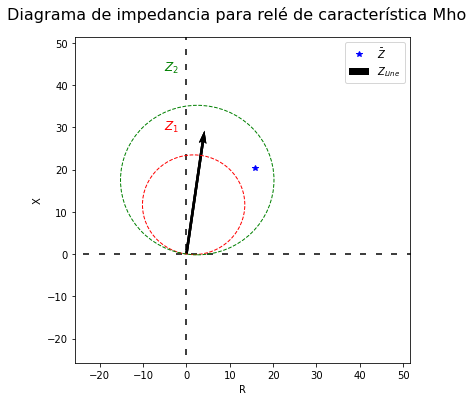

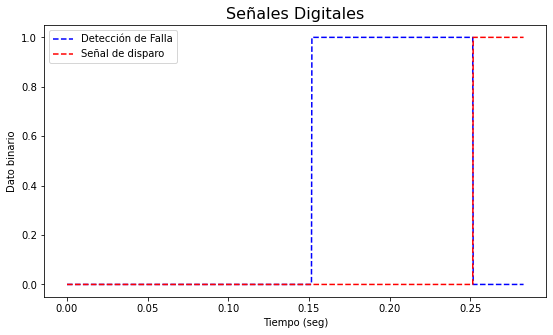

,Función,Zona,Tipo Falla,Detección [seg],Disparo [seg],Distancia [%]
0,Distancia (21),Zona 2,{ABC},0.151817,0.251813,87.26


In [36]:
zones_plot(Z1L, zone1, zone2, imp)
if activa == 1:
    print('Se activó la función 21')    
    graf_21()
    results = results_21()
    display(results.head())
else:
    print('Se activó la función 51')
    graf_51()
    results = results_51()
    display(results.head())